# Non-negative Tucker decomposition in Tensorly >=0.6

Since version 0.6 in Tensorly, two algorithms are available to compute non-negative Tucker decomposition:
- Multiplicative updates (MU) (already in Tensorly <0.6)
- Non-negative Alternating Least Squares using Hierarchical Alternating Least Squares (HALS) 

Non-negativity is an important constraint to handle for tensor decompositions. One could expect that core and factors must have only non-negative values after it is obtained from a non-negative tensor. As it is demonstrated in the figure below, Tucker decomposition includes core (G) and factors (A, B, C).

$$T = [| G; A, B , C |]$$
We need to solve the following problem for each factor (e.g. factor A here):

$$\min_{A \geq 0} ||T_{[1]} - A  G_{[1]}(B\otimes C)^T||_F^2$$

Here, $G_{[i]}$ represents ith mode unfolding of the core. To update the core, we need the solve following problem:

$$\min_{g \geq 0} ||t -   (A\otimes B \otimes C)g ||_F^2$$
where t and g are the vectorized data tensor $T$ and core $G$.

To update the factors, we will use HALS and to update the core, we have two different algorithms Active Set (AS) and Fast Iterative Shrinkage-Thresholding Algorithm (FISTA) in Tensorly. While FISTA is an accelerated gradient method for non-negative or unconstrained problems, AS is the widely used non-negative least square solution proposed by Lawson and Hanson in 1974. Both algorithms return non-negative core and FISTA is the default algorithm for HALS Tucker decomposition in Tensorly.

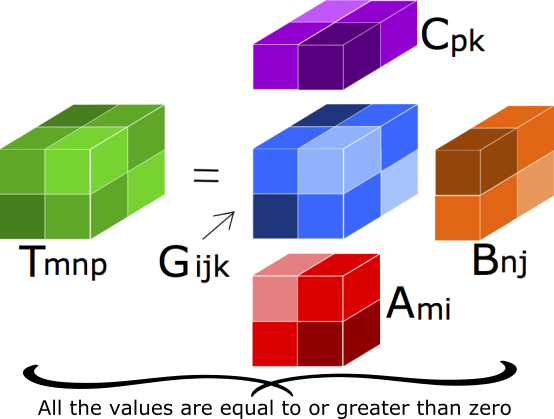

MU algorithm solves the minimization problem by updating all the values of each factor separately. On the other hand, HALS algorithm aims at columnwise update for each factor separately. In the figure below, M represents a tensor or matrix which can be decomposed into factors W and H. Two different equations are demonstrated in order to make explicit difference between MU and HALS. In these quations, `k` is the iteration and `p` is the updated column.

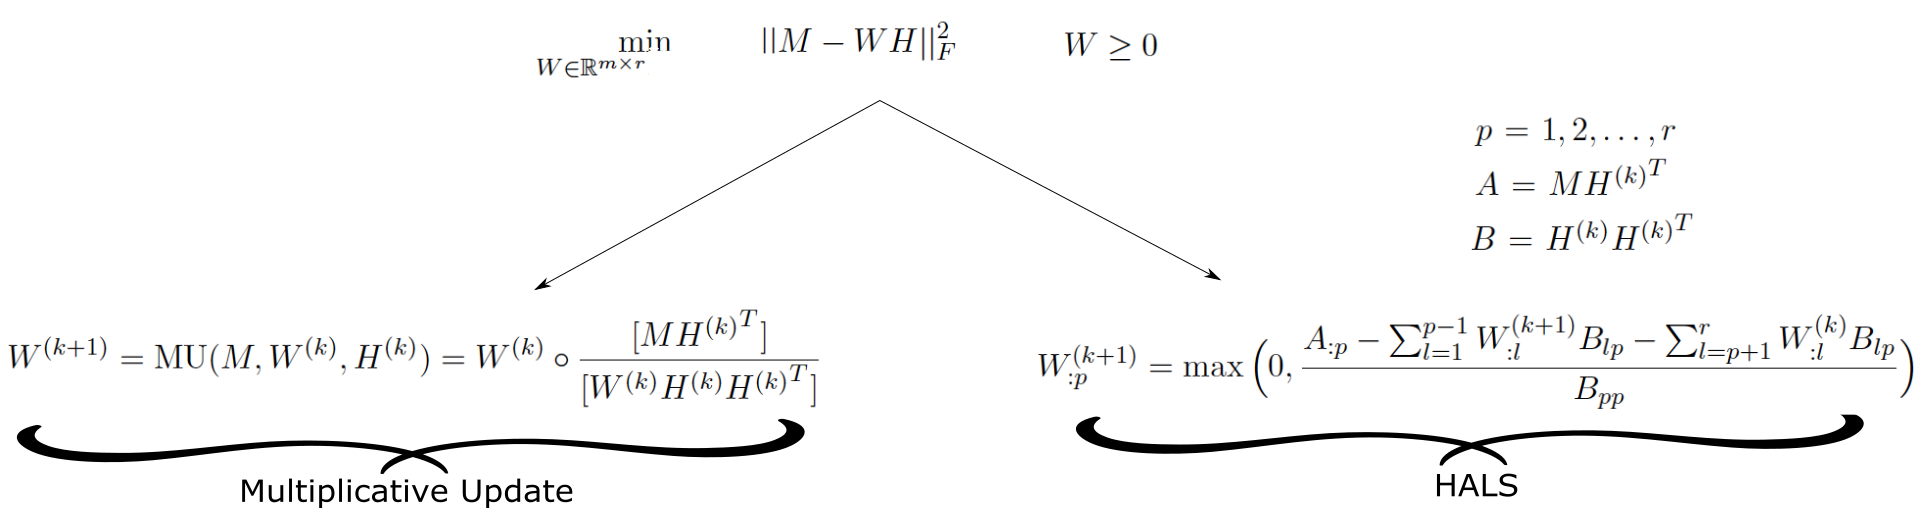

We start by importing the toolbox as well as the required functions from tensorly and some libraries such as numpy and time. It should be noted that tensorly uses numpy backend as default. However, other backends (pytorch, tensorflow, mxnet and jax) can be used for NN-Tucker decomposition as well.

In [1]:
import numpy as np
import tensorly as tl
from tensorly.decomposition import non_negative_tucker, non_negative_tucker_hals
import time

There are several ways to create a tensor with non-negative entries in tensorly. Here we chose to generate a random tensor from the sequence of integers from 1 to 1000.

In [2]:
#tensor generation
array=np.random.randint(1000, size=(10,30,40))
tensor=tl.tensor(array,dtype='float')

First, multiplicative update can be implemented as:

In [3]:
tic = time.time()
tensor_mu, error_mu = non_negative_tucker(tensor, rank=[3,3,3], n_iter_max=100, tol=1e-12, return_errors=True)
tucker_reconstruction_mu = tl.tucker_to_tensor(tensor_mu)
time_mu= time.time()-tic

Here, we also compute the output tensor from the decomposed factors by using the `tucker_to_tensor` function. The tensor `tucker_reconstruction_mu` is therefore a low-rank non-negative approximation of the input tensor `tensor`.

HALS algorithm with FISTA can be calculated as:

In [4]:
ticnew = time.time()
tensor_hals_fista, error_fista = non_negative_tucker_hals(tensor, rank=[3,3,3], algorithm='fista', return_errors=True)
tucker_reconstruction_fista = tl.tucker_to_tensor(tensor_hals_fista)
time_fista = time.time()-ticnew

As a second option, HALS algorithm with Active Set can be called as follows:

In [5]:
ticnew = time.time()
tensor_hals_as, error_as = non_negative_tucker_hals(tensor, rank=[3,3,3], algorithm='active_set', return_errors=True)
tucker_reconstruction_as = tl.tucker_to_tensor(tensor_hals_as)
time_as = time.time()-ticnew

To compare the various methods, first we may look at each algorithm processing time:

In [6]:
print('time for tensorly nntucker:'+' ' +str("{:.2f}".format(time_mu)))
print('time for HALS with fista:'+' ' +str("{:.2f}".format(time_fista)))
print('time for HALS with as:'+' ' +str("{:.2f}".format(time_as)))

time for tensorly nntucker: 0.09
time for HALS with fista: 1.14
time for HALS with as: 0.39


All algorithms should run with about the same number of iterations on our example, so at first glance the MU algorithm is faster (i.e. has lower per-iteration complexity).

A second way to compare methods is to compute the error between the output and input tensor. In tensorly, there is a function to compute Root Mean Square Error (RMSE):

In [7]:
from tensorly.metrics.regression import RMSE
print('RMSE tensorly nntucker:'+' ' +str(RMSE(tensor,tucker_reconstruction_mu)))
print('RMSE for hals with fista:'+' ' +str(RMSE(tensor,tucker_reconstruction_fista)))
print('RMSE for hals with as:'+' ' +str(RMSE(tensor,tucker_reconstruction_as)))

RMSE tensorly nntucker: 284.7904721270734
RMSE for hals with fista: 282.07646431687283
RMSE for hals with as: 281.85485608475744


According to the RMSE results, HALS is better than the multiplicative update with both FISTA and active set core update options. We can better appreciate the difference in convergence speed on the following error per iteration plot:

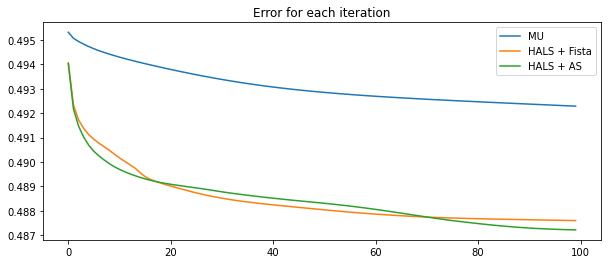

In [8]:
import matplotlib.pyplot as plt
def each_iteration(a,b,c,title):
    fig=plt.figure()
    fig.set_size_inches(10, fig.get_figheight(), forward=True)
    plt.plot(a)
    plt.plot(b)
    plt.plot(c)
    plt.title(str(title))
    plt.legend(['MU','HALS + Fista','HALS + AS'], loc='upper right')
each_iteration(error_mu, error_fista, error_as, 'Error for each iteration')

In conclusion, on this quick test, it appears that the HALS algorithm gives much better results than the MU original tensorly methods. Our recommendation is to use HALS as a default, and only resort to MU in specific cases (only encountered by expert users most likely). Besides, in this experiment FISTA and active set give very similar results, however active set may last longer when it is used with higher ranks according to our experience. Therefore, we recommend to use FISTA with high rank decomposition.

# Reference

1- Gillis, N., & Glineur, F. (2012). Accelerated multiplicative updates and hierarchical ALS algorithms for nonnegative matrix factorization. Neural computation, 24(4), 1085-1105.  [Link](https://www.mitpressjournals.org/doi/abs/10.1162/NECO_a_00256)